In [ ]:
!pip install gymnasium
!pip install pygame

# Carga y exploración de un entorno de Gymnasium

In [1]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import multiprocessing

import subprocess
import os
import json
import glob
import pickle

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Dispositivo utilizado: {device}")

SEED = 42

# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)

# -------------------- EVALUACIÓN DE LA POLÍTICA --------------------

def evaluar_politica(agente, num_episodios=100):
    """Evalúa la política del agente ejecutando múltiples episodios y muestra estadísticas."""

    env = agente.env
    recompensas = []
    longitudes = []
    semillas_fallidas = []

    pbar = tqdm(range(num_episodios), desc="Evaluando", dynamic_ncols=True)
    for i in pbar:
        random.seed(i)
        np.random.seed(i)
        torch.manual_seed(i)
        env.action_space.seed(i)
        state, _ = env.reset(seed=i)
        done = False
        total_reward = 0
        posiciones = []
        pasos = 0

        terminated = False
        truncated = False
        
        while not done:
            posiciones.append(state[0])
            action = agente.seleccionar_accion_greedy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            pasos += 1
    
            if truncated:
                semillas_fallidas.append(i)

        recompensas.append(total_reward)
        longitudes.append(pasos)
            
        env.close()

    # Resumen estadístico
    print("📊 Resultados de evaluación:")
    print(f"  Episodios evaluados: {num_episodios}")
    print(f"  Recompensa media:    {np.mean(recompensas):.2f} ± {np.std(recompensas):.2f}")
    print(f"  Recompensa min/max:  {np.min(recompensas):.2f} / {np.max(recompensas):.2f}")

    print(f"  Episodios exitosos:  {num_episodios - len(semillas_fallidas)}")
    print(f"  Episodios fallidos:  {len(semillas_fallidas)}")
    print(f"  Semillas fallidas: {semillas_fallidas}")



Dispositivo utilizado: cuda


# Objeto Agente-DeepQLearning

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class AgenteDQLearning:
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 alpha=1e-3, gamma=0.99, buffer_size=100000, batch_size=64,
                 target_update_freq=1000):
        
        self.env = env
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_size)
        self.target_update_freq = target_update_freq

        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(self.nS, self.nA).to(self.device)
        self.target_net = DQN(self.nS, self.nA).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.alpha)
        self.stats = []
        self.episode_lengths = []
        self.steps_done = 0

    def guardar_agente(self, name="agente_dqn.pkl"):
        # Crear un diccionario con todo lo importante
        modelo_guardado = {
            "params": {
                "alpha": self.alpha,
                "gamma": self.gamma,
                "epsilon": self.epsilon,
                "epsilon_min": self.epsilon_min,
                "epsilon_decay": self.epsilon_decay,
                "buffer_size": self.buffer.maxlen,
                "batch_size": self.batch_size,
                "target_update_freq": self.target_update_freq,
            },
            "policy_state_dict": self.policy_net.state_dict(),
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
        }
        
        # Guardar en un archivo
        with open(name, "wb") as f:
            pickle.dump(modelo_guardado, f)

    @staticmethod
    def cargar_agente(name="agente_dqn.pkl"):
        # Cargar el archivo
        with open(name, "rb") as f:
            data = pickle.load(f)
        
        # Reconstruir el entorno
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
        
        # Reconstruir el agente con los mismos hiperparámetros
        agent = AgenteDQLearning(env, **data["params"])
        agent.policy_net.load_state_dict(data["policy_state_dict"])
        agent.stats = data["stats"]
        agent.episode_lengths = data["episode_lengths"]
    
        return agent


    def seleccionar_accion(self, estado):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy(estado)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, estado):
        """Selecciona la mejor acción según la política actual (greedy)."""
        estado_tensor = torch.tensor(estado, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_vals = self.policy_net(estado_tensor)
        return torch.argmax(q_vals, dim=1).item()

    
    def _epsilon_soft_policy(self, estado):
        """Devuelve una política epsilon-soft como vector de probabilidades."""
        estado_tensor = torch.tensor(estado, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_vals = self.policy_net(estado_tensor).cpu().numpy().squeeze()
        
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_vals)
        policy[best_action] += 1.0 - self.epsilon
        return policy


    def almacenar(self, s, a, r, s_, done):
        self.buffer.append((s, a, r, s_, done))

    def _actualizar_red(self):
        if len(self.buffer) < self.batch_size:
            return

        batch = random.sample(self.buffer, self.batch_size)
        s, a, r, s_, d = zip(*batch)

        s = torch.tensor(np.array(s), dtype=torch.float32).to(self.device)
        a = torch.tensor(np.array(a), dtype=torch.int64).unsqueeze(1).to(self.device)
        r = torch.tensor(np.array(r), dtype=torch.float32).unsqueeze(1).to(self.device)
        s_ = torch.tensor(np.array(s_), dtype=torch.float32).to(self.device)
        d = torch.tensor(np.array(d), dtype=torch.float32).unsqueeze(1).to(self.device)

        q_vals = self.policy_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1, keepdim=True)[0]
            target = r + self.gamma * q_next * (1 - d)

        loss = nn.MSELoss()(q_vals, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps_done % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.env.reset(seed=SEED)
        self.env.action_space.seed(SEED)

        acumulador_recompensas = 0.0

        pbar = tqdm(range(num_episodes), desc="Entrenando", dynamic_ncols=True)
        
        for t in pbar:
            estado, _ = self.env.reset()
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                accion = self.seleccionar_accion(estado)
                estado_siguiente, recompensa, terminado, truncado, _ = self.env.step(accion)
                done = terminado or truncado

                self.almacenar(estado, accion, recompensa, estado_siguiente, done)
                self._actualizar_red()

                estado = estado_siguiente
                total_reward += recompensa
                pasos += 1
                self.steps_done += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

            pbar.set_postfix({'Recompensa': total_reward})
            
            # Epsilon decay
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return self.policy_net

In [3]:
# Ejecución de ejemplo
env = gym.make("MountainCar-v0")
env.reset(seed=SEED)
agent = AgenteDQLearning(env, alpha=0.001, gamma=1.0, epsilon=1.0)
agent.entrenar(num_episodes=3000)

Entrenando: 100%|███████████████████████████████████████████████████| 3000/3000 [30:14<00:00,  1.65it/s, Recompensa=-92]


DQN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [4]:
agent.guardar_agente()

In [5]:
agente = AgenteDQLearning.cargar_agente()

# Resultados de agente Deep-Q-Learning

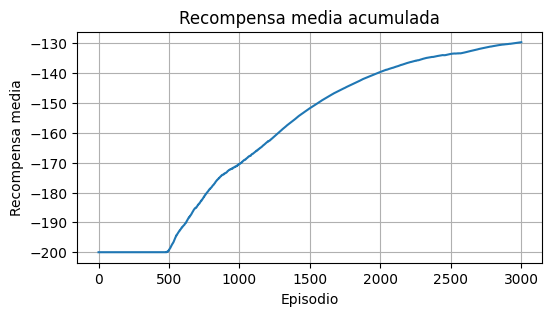

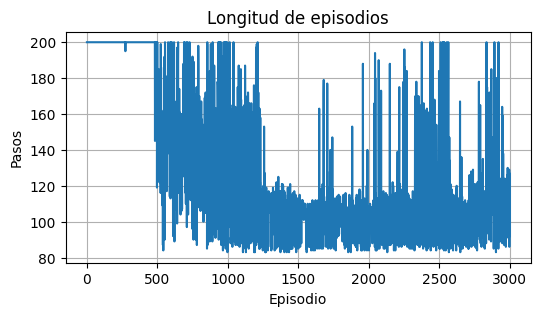

In [6]:
mostrar_resultados_agente_continuo(agente)

In [7]:
evaluar_politica(agente, num_episodios=10000)

Evaluando: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [12:00<00:00, 13.87it/s]

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -106.37 ± 11.19
  Recompensa min/max:  -130.00 / -87.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


In [ ]:
def grabar_video_agente(agente, seed, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    done = False
    total_reward = 0
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)

        action = agente.seleccionar_accion_greedy(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

In [ ]:
nombre_archivo = "video_mountaincar_dqn.gif"

grabar_video_agente(agente, seed=55, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")